
# <p style="text-align: center;">MIS382: Advanced Predictive Modeling</p>
# <p style="text-align: center;">Assignment 3</p>
## <p style="text-align: center;">Total points: 75</p>
## <p style="text-align: center;">Due: Tuesday, October 23rd, submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Only one student per team needs to submit the assignment on Canvas.  **Please include the name and UTEID for both students on all submitted files (including this notebook).** In addition, please make sure that **your filename includes your EID** (ex. ss324.jpynb or ss324_mj345.jpypb).

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

#### Hope Knopf - hk23735
#### Chelsea Matthews - cm58685

# Question 1a - Stochastic Gradient Descent (25pts)

1. (5pts) Using stochastic gradient descent, derive the coefficent updates for all 4 coefficients of the model: $$ y = w_0 + w_1x_1 + w_2x_1^2 + w_3x_1x_2 $$ Hint: start from the cost function (Assume sum of squared error). If you write the math by hand, include the image in your notebook.


2. (15pts) Write Python code for an SGD solution to the non-linear model $$ y = w_0 + w_1x_1 + w_2x_1^2 + w_3x_1x_2$$ Try to format similarly to scikit-learn's models. Your class should take as input the learning_rate, regularization_constant and number of epochs. The fit method must take as input X,y and a choice of update_rule as 'sgd' or 'sgd_momentum' or 'rmsprop'(Notes on implementation below). The _predict_ method takes an X value (optionally, an array of values). Use your new gradient descent regression to predict the data given in 'samples.csv', for 15 epochs, using learning rates: [.0001, .001, .01, 0.1, 1, 10, 100] and regularization constants in the range: [0,10,100] . Plot MSE and the $w$ parameters as a function of epoch (for 15 epochs) for the best 2 combinations of learning_rate and regularization for SGD, SGD-Momentum and RMSProp. I.e., you should have one plot of MSE and another for the parameter updates for SGD, SGD-Momentum and RMSProp (6 plots total).


3. (2pts) Report the MSE at the end of 15 epochs for both combinations.


4. (3pts) Based on the experiments, which of the 3 techniques allowed for larger initial setting of the learning_rate? Why?


# Notes on SGD with momentum
Momentum helps accelerate SGD in relevant direction and dampens the oscillations. It tries to maintain the direction in which the gradient vector was already pointing and adjusts the direction slowly with the new gradients. The steps can be listed below :
1. v[t] = mu * v[t-1] - (learning_rate)*(gradient)
2. w = w + v

Set mu = 0.90. Initialize v with zeros.


# Notes on RMSProp
RMSProp (http://ruder.io/optimizing-gradient-descent/) differs from vanilla SGD in that the learning rate of each weight changes over updates. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate.  In particular, it uses a moving average of squared gradients as cache. The learning_rate is divided by the cache, resulting in a different learning rate for each weight. A consequence of this update rule is that weights that have already seen large gradients (made large jumps) make smaller updates in subsequent iterations.
Specifically, the steps can be listed as below:
1. cache = (decay_rate)*(cache) + (1 - decay_rate)*(gradients^2) 
2. weights = weights - ((learning_rate)/sqrt(cache+1e-6))*gradients

Use decay_rate = 0.90. Initialize cache with zeros.

# (Optional) Notes on Training with Gradient Descent
1. Compute error: This consists of a prediction error and a regularization term. From an implementation perspective, this is a function that takes as input the truth, prediction and regularization hyperparameter and returns an error
2. Compute gradients: Take a derivative of the error in terms of the weights. This can be modelled as a function that takes as input the error and features and returns the gradients for each weight
3. Update weights: Weight updates can be done using vanilla SGD or adaptive techniques. The update function takes as inputs the gradient and hyperparameters and returns the new weights.

## Answer

### Part 1

We update our weight, $w_{j}$, using the following rule: $$w_{j} = w_{j} - \eta\Delta w_{j} $$

where $\eta$ is the learning rate, $\Delta w_{j} = \frac {\delta E_{n}}{\delta w_{j}}$ and $E_{n}$ is our cost function.

 $\Delta w_{j}$ is derived below

$Y$ is:

$$ y = w_0 + w_1x_1 + w_2x_1^2 + w_3x_1x_2$$
Let $t_{n}$ be a test data point.

Rewrite cost function, $E_{n}$ as:

$$ E_{n} = (t_{n} - y_{n})^2 $$
Our coefficient update, $\Delta w$, is the partial derivative $\frac {\delta E_{n}}{\delta w_{j}}$. Using the chain rule and including $\eta$, we get:

$$\frac {\delta E_{n}}{\delta w_{0}} = -2\eta* (t_{n} - y_{n}) $$$$\frac {\delta E_{n}}{\delta w_{1}} = -2\eta * x_{1}(t_{n} - y_{n}) $$$$\frac {\delta E_{n}}{\delta w_{2}} = -2\eta * x_{1}^2(t_{n} - y_{n}) $$$$\frac {\delta E_{n}}{\delta w_{3}} = -2\eta * x_{1}x_{2}(t_{n} - y_{n}) $$
Final weight updates:

$$ w_{0} = w_{0} + 2\eta* (t_{n} - y_{n}) $$$$ w_{1} = w_{1} + 2\eta * x_{1}(t_{n} - y_{n})$$$$ w_{2} = w_{2} + 2\eta * x_{1}^2(t_{n} - y_{n}) $$$$ w_{3} = w_{3} + 2\eta * x_{1}x_{2}(t_{n} - y_{n}) $$


### Part 2

In [1]:
#import necessary packages 
import pandas as pd
from pandas import Series, DataFrame
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
warnings.filterwarnings("ignore")
%matplotlib inline

In [32]:
# Read in file
data = pd.read_csv("samples.csv",names=['index','x1','x2','target'],header=0)

#create copy of file to get our target variable s
import copy
data_copy = copy.deepcopy(data)
data_copy['x1*x1'] = data['x1']*data['x1']
data_copy['x1*x2'] = data['x1']*data['x2']

#Dropping first column
data_copy = data_copy.drop(data_copy.columns[0],axis = 1)

X = np.array(data_copy[['x1','x1*x1','x1*x2']])
y = data_copy['target']


In [33]:
#class should take as input the learning_rate, regularization_constant and number of epochs
class StochasticGradient():
    
    
    def __init__ (self,learning_rate=0.0001,regularization_constant=10.0,epochs=15):
        #here we initialize our class
        self.coef_ = None
        self.intercept_ = None
        self.learning_rate = learning_rate
        self.regularization_constant = regularization_constant
        self.epochs = epochs

    def fit(self, X, y, update_rule = 'sgd', mu = 0.9, decay_rate = 0.9):
        #defining fit
        #making sgd the default and giving two alternative update rules 
        #self.regularization_constant = np.repeat(self.regularization_constant, X.shape[1])
        #self.regularization_constant[0] = 0
        #regularization_constant = [0,10,100]
        
        X = np.c_[np.ones((X.shape[0])), X]        
        coef = np.ones((X.shape[1]))
        
        self.regularization_constant = np.repeat(self.regularization_constant, X.shape[1])
        self.regularization_constant[0] = 0
                     
        if update_rule == 'sgd_momentum':
            v = np.zeros((X.shape[1]))
        elif update_rule == 'rmsprop':
            cache = np.zeros((X.shape[1]))
            
                               
        for j in range (self.epochs):
            
            for i in range(len(X)):         
                #defining gradient 
                predicted_y = np.array(X[i]).reshape(1,-1).dot(coef)
                error = y[i] - predicted_y
                gradient = -2*error.dot(np.array(X[i]).reshape(1,-1)) + 2*self.regularization_constant.dot(coef)
                
                #Update weights depending on the choice of update rule
                if update_rule == 'sgd':
                    coef = coef - self.learning_rate*gradient
                elif update_rule == 'sgd_momentum':
                    v = v*mu  - self.learning_rate*(gradient)
                    coef = coef + v
                elif update_rule == 'rmsprop':
                    cache = decay_rate*cache + (1 - decay_rate)*(gradient**2)
                    coef = coef - ((self.learning_rate)/np.sqrt(cache*(10**(-6))))*gradient
                else:
                    print ("Please enter the correct update_rule. Correct update_rule include the following -\n")
                    print ("sgd","sgd_momentum","rmsprop")
                    break                    
                
            self.intercept_ = coef[0]
            self.coef_ = coef[1:]
                        
        return coef
         
    def predict(self, X):
        if len(X.shape)==1:
            X = X.reshape(1,-1)
        
        return self.intercept_ +  X.dot(self.coef_) 
    
    def mean_squared_error(self,y_true,y_predicted):
        mse = np.mean((y_true - y_predicted)**2)
        return mse

In [37]:
#Create a function to output your MSE for the different learning rates & reg constants 

learning_rate = [0.0001, .001, .01, 0.1, 1, 10, 100]
regularization_constant = [0,10,100]

def calculate_min_mse(X,y,sgd_variant,learning_rate,regularization_constant):
    df = pd.DataFrame(columns = ['mse','learning_rate','regularization'])
    for k in learning_rate:
        for j in regularization_constant:
            sgd = StochasticGradient(learning_rate = k, regularization_constant=j,epochs = 15)
            w = sgd.fit(X,y,update_rule = sgd_variant)
            y_predicted = sgd.predict(X)
            mse = sgd.mean_squared_error(y,y_predicted)
            df.loc[len(df)] = [mse,k,j]
                        
    min_mse = df[df['mse']==df['mse'].min()]
    return min_mse

sgd_combo = calculate_min_mse(X,y,'sgd',learning_rate,regularization_constant)
sgd_momentum_combo = calculate_min_mse(X,y,'sgd_momentum',learning_rate,regularization_constant)
rmsprop_combo = calculate_min_mse(X,y,'rmsprop',learning_rate,regularization_constant)

In [39]:
#return the best combinations of parameters for all 3 methods
print ('The best combination of learning rate and regularization constant for SGD method is \n\n', sgd_combo,'\n\n')
print ('The best combination of learning rate and regularization constant for SGD-Momentum method is \n\n', sgd_momentum_combo,'\n\n')
print ('The best combination of learning rate and regularization constant for RMSProp method is \n\n', rmsprop_combo,'\n\n')


The best combination of learning rate and regularization constant for SGD method is 

         mse  learning_rate  regularization
3  0.067935          0.001             0.0 


The best combination of learning rate and regularization constant for SGD-Momentum method is 

         mse  learning_rate  regularization
0  0.084631         0.0001             0.0 


The best combination of learning rate and regularization constant for RMSProp method is 

         mse  learning_rate  regularization
0  0.156538         0.0001             0.0 




In [44]:
#need coefficients and mse for the best case scenarios 
epochs = 15
sgd_best_learning_rate = sgd_momentum_min_mse.iloc[0]['learning_rate']
sgd_best_regularization = sgd_momentum_min_mse.iloc[0]['regularization']

def mse_coef_per_epoch(X,y,sgd_variant,learning_rate,regularization_constant,epochs=15):
    
    df = pd.DataFrame(columns = ['epochs','weights','mse'])

    for i in range(epochs):
        sgd = StochasticGradient(learning_rate = learning_rate,\
                                    regularization_constant=regularization_constant,\
                                    epochs = i+1)
    
        w = sgd.fit(X,y,update_rule = sgd_variant)
        y_predicted = sgd.predict(X)
        mse = sgd.mean_squared_error(y,y_predicted)
        df.loc[len(df)] = [i+1,w,mse]
    return df
    
sgd_mse_parameters = mse_coef_per_epoch(X,y,'sgd',sgd_min_mse.iloc[0]['learning_rate'],\
                                     sgd_min_mse.iloc[0]['regularization'])
sgd_momentum_mse_parameters = mse_coef_per_epoch(X,y,'sgd_momentum',sgd_momentum_min_mse.iloc[0]['learning_rate'],\
                                     sgd_momentum_min_mse.iloc[0]['regularization']) 
rmsprop_mse_parameters = mse_coef_per_epoch(X,y,'rmsprop',rmsprop_min_mse.iloc[0]['learning_rate'],\
                                     rmsprop_min_mse.iloc[0]['regularization'])

In [45]:
#Plot MSE and the  w  parameters as a function of epoch (for 15 epochs) for the best 2 combinations of learning_rate 
#and regularization for SGD, SGD-Momentum and RMSProp

#you should have one plot of MSE and another for the parameter updates for SGD, SGD-Momentum and RMSProp 
#(6 plots total).


#eta is learning rate & regularization is lambda 

Text(0.5,1,'Parameters vs Epoch for RMSProp')

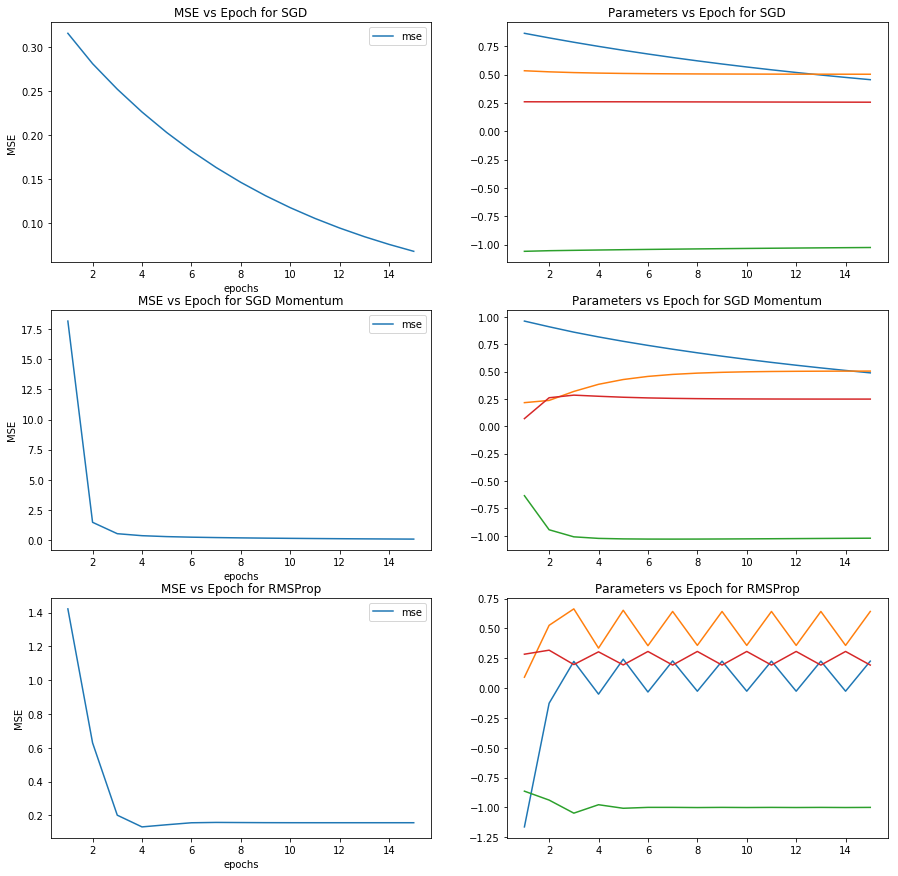

In [46]:
#plotting the three cases

fig, axes = plt.subplots(nrows=3, ncols=2, sharey = False, figsize = (15,15))
sgd_mse_parameters.plot('epochs','mse',ax=axes[0,0])
axes[0,0].set_ylabel('MSE')
axes[0,0].set_title('MSE vs Epoch for SGD')

axes[0,1].plot(range(1,16),np.stack((sgd_mse_coef_epochs['weights'].values)))
axes[0,1].set_title('Parameters vs Epoch for SGD')

sgd_momentum_mse_parameters.plot('epochs','mse',ax=axes[1,0])
axes[1,0].set_ylabel('MSE')
axes[1,0].set_title('MSE vs Epoch for SGD Momentum')

axes[1,1].plot(range(1,16),np.stack((sgd_momentum_mse_coef_epochs['weights'].values)))
axes[1,1].set_title('Parameters vs Epoch for SGD Momentum')

rmsprop_mse_parameters.plot('epochs','mse',ax=axes[2,0])
axes[2,0].set_ylabel('MSE')
axes[2,0].set_title('MSE vs Epoch for RMSProp')

axes[2,1].plot(range(1,16),np.stack((rmsprop_mse_coef_epochs['weights'].values)))
axes[2,1].set_title('Parameters vs Epoch for RMSProp')

#### Part 3

In [ ]:
#Report the MSE at the end of 15 epochs for both combinations

In [47]:
print('The lowest MSE after 15 epochs from SGD is',sgd_min_mse.iloc[0]['mse'])
print('The lowest MSE after 15 epochs from SGD_Momentum is',sgd_momentum_min_mse.iloc[0]['mse'])
print('The lowest MSE after 15 epochs from RMSProp is',rmsprop_min_mse.iloc[0]['mse'])

The lowest MSE after 15 epochs from SGD is 0.06793481950619042
The lowest MSE after 15 epochs from SGD_Momentum is 0.08463066016076069
The lowest MSE after 15 epochs from RMSProp is 0.15653846838167945


#### Part 4

In [ ]:
#Based on the experiments, which of the 3 techniques allowed for larger initial setting of the learning_rate? Why?

RMSPRop allowed for the largest initial setting of the learning_rate.  This is because it divides the learning rate by an exponentially decaying average of squared gradients and convergence is quicker in this case 

# Question 2 - Multi-layer perceptron Regressor (15 pts)

In this question, you will explore the application of Multi-layer Perceptron (MLP) regression using sklearn package in Python;
http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html.


We will use the OpenCL gemm kernel performance prediction dataset for this problem; https://archive.ics.uci.edu/ml/datasets/SGEMM+GPU+kernel+performance.

Following code will pre-process the data and split the data into training and test set using [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with **random state 30** and **test_size = 0.25**.

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
%matplotlib inline

data = pd.read_csv('sgemm_product.csv') 
data['target'] = 0.25*(data['Run1 (ms)'] + data['Run2 (ms)']+ data['Run3 (ms)'] + data['Run4 (ms)'])
y = data['target']
y = y.as_matrix()
X = data.drop(['target','Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=30)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(181200, 14) (181200,) (60400, 14) (60400,)


In [30]:
#scale the data using StandardScaler
Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)

X_test = Scaler.transform(X_test)


One more thing to use in this problem is [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Instead of fitting a model on original data, use StandardScaler to make each feature centered ([Example](http://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html#sphx-glr-auto-examples-applications-plot-prediction-latency-py)). Whenever you have training and test data, fit a scaler on training data and use this scaler on test data. Here, scale only features (independent variables), not target variable y. 

1) (5pts) Use [sklearn.neural_nework.MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) to do a 5-fold cross validation using sklearn's [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). The cross validation must be performed on the **training data**. Use following parameter settings for MLPRegressor:

    activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
    batch_size=30, learning_rate_init = 0.005
    
Now, consider the following settings for the number of hidden units:
    
   (a) *hidden_layer_sizes = (2,)* 
   
   (b) *hidden_layer_sizes = (10,)*
   
   (c) *hidden_layer_sizes = (30,)*
   
   (d) *hidden_layer_sizes = (50,)*
   
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model.
   
   
2) (5pts) Now, using the same parameters used in part 1), train MLPRegressor models on the entire training set and report the RMSE score for both the trainnig and testing sets (again, use StandardScaler). Which of the four models ((a)-(d)) performs the best? Briefly analyze and discuss the results, commenting on the number of hidden units.


3) (5pts) MLPRegressor has a built-in attribute *loss\_curve\_* which returns the loss at each epoch (misleadingly referred to as "iteration" in scikit documentation, though they use epoch in the actual code!). For example, if your model is named as *my_model* you can call it as *my\_model.loss\_curve\_* ([example](http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py)). Plot three curves using below conditions (a, b, c) in one figure, where *X-axis* is epoch  number and *Y-axis* is squared root of *loss\_curve\_* valu;:

   (a) *hidden_layer_sizes = (1,)* 
   
   (b) *hidden_layer_sizes = (5,)*
   
   (c) *hidden_layer_sizes = (10,)*

## Answer

### Part 1

In [31]:
#5-fold cross validation using sklearn's KFold on training data 

#activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
#batch_size=30, learning_rate_init = 0.005

### hidden_layer_sizes = (2,)
mlp2 = MLPRegressor(hidden_layer_sizes=(2,), activation='tanh', solver='sgd', learning_rate='constant', 
                    random_state=42, batch_size=30, learning_rate_init=0.005)

## hidden_layer_sizes = (10,)
mlp10 = MLPRegressor(hidden_layer_sizes=(10,), activation='tanh', solver='sgd', learning_rate='constant',
                    random_state=42, batch_size=30, learning_rate_init=0.005)

## hidden_layer_sizes = (30,)
mlp30 = MLPRegressor(hidden_layer_sizes=(30,), activation='tanh', solver='sgd', learning_rate='constant',
                    random_state=42, batch_size=30, learning_rate_init=0.005)

## hidden_layer_sizes = (50,)
mlp50 = MLPRegressor(hidden_layer_sizes=(50,), activation='tanh', solver='sgd', learning_rate='constant', 
                     random_state=42, batch_size=30, learning_rate_init=0.005)


In [32]:
#Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model

from sklearn.metrics import mean_squared_error as MSE
kf = KFold(n_splits=5, random_state=42)
kf.get_n_splits(X_train)

for train, test in kf.split(X_train):
    
    # fit the models
    mlp2.fit(X_train[train], y_train[train])
    mlp10.fit(X_train[train], y_train[train])
    mlp30.fit(X_train[train], y_train[train])
    mlp50.fit(X_train[train], y_train[train])
    
    #generate the prediction
    mlp2_pred = mlp2.predict(X_train[test])
    mlp10_pred = mlp10.predict(X_train[test])
    mlp30_pred = mlp30.predict(X_train[test])
    mlp50_pred = mlp50.predict(X_train[test])
    
    
    #calculate the MSE
    Mse2 = MSE(y_train[test], mlp2_pred)
    Mse10 = MSE(y_train[test], mlp10_pred)
    Mse30 = MSE(y_train[test], mlp30_pred)
    Mse50 = MSE(y_train[test], mlp50_pred)

print('RMSE for hidden layer size=(2,) is ', np.sqrt(Mse2))
print('RMSE for hidden layer size=(10,) is ', np.sqrt(Mse10))
print('RMSE for hidden layer size=(30,) is ', np.sqrt(Mse30))
print('RMSE for hidden layer size=(50,) is ', np.sqrt(Mse50))

RMSE for hidden layer size=(2,) is  244.338794804461
RMSE for hidden layer size=(10,) is  223.85933984435954
RMSE for hidden layer size=(30,) is  208.13047538430712
RMSE for hidden layer size=(50,) is  172.77058013530495


### Part 2

In [33]:
# train MLPRegressor models on the entire training set and report the RMSE score for both the training and testing sets

#fit models
mlp2.fit(X_train, y_train)
mlp10.fit(X_train, y_train)
mlp30.fit(X_train, y_train)
mlp50.fit(X_train, y_train)

#predict the result for both train and test set
mlp2_pred_train = mlp2.predict(X_train)
mlp2_pred_test = mlp2.predict(X_test)

mlp10_pred_train = mlp10.predict(X_train)
mlp10_pred_test = mlp10.predict(X_test)

mlp30_pred_train = mlp30.predict(X_train)
mlp30_pred_test = mlp30.predict(X_test)

mlp50_pred_train = mlp50.predict(X_train)
mlp50_pred_test = mlp50.predict(X_test)

 #calculate the MSE
Mse2_train = MSE(y_train, mlp2_pred_train)
Mse2_test = MSE(y_test, mlp2_pred_test)

Mse10_train = MSE(y_train, mlp10_pred_train)
Mse10_test = MSE(y_test, mlp10_pred_test)

Mse30_train = MSE(y_train, mlp30_pred_train)
Mse30_test = MSE(y_test, mlp30_pred_test)

Mse50_train = MSE(y_train, mlp50_pred_train)
Mse50_test = MSE(y_test, mlp50_pred_test)

print('Train RMSE for hidden layer size=(2,) is ', np.sqrt(Mse2_train))
print('Test RMSE for hidden layer size=(2,) is ', np.sqrt(Mse2_test))

print('Train RMSE for hidden layer size=(10,) is ', np.sqrt(Mse10_train))
print('Test RMSE for hidden layer size=(10,) is ', np.sqrt(Mse10_test))

print('Train RMSE for hidden layer size=(30,) is ', np.sqrt(Mse30_train))
print('Test RMSE for hidden layer size=(30,) is ', np.sqrt(Mse30_test))

print('Train RMSE for hidden layer size=(50,) is ', np.sqrt(Mse50_train))
print('Test RMSE for hidden layer size=(50,) is ', np.sqrt(Mse50_test))


Train RMSE for hidden layer size=(2,) is  318.3815555615713
Test RMSE for hidden layer size=(2,) is  311.6268761455143
Train RMSE for hidden layer size=(10,) is  241.72623069388493
Test RMSE for hidden layer size=(10,) is  239.22077347589266
Train RMSE for hidden layer size=(30,) is  186.64791440239347
Test RMSE for hidden layer size=(30,) is  185.33341308719807
Train RMSE for hidden layer size=(50,) is  150.05944858114796
Test RMSE for hidden layer size=(50,) is  148.66108223560596


#### The hidden layer size (50,) had the lowest RMSE both in sample and out of sample.  RMSE's seem to decrease as the number of hidden layers increase, which leads me to believe that increasing hidden layers improve performance of the model.

### Part 3

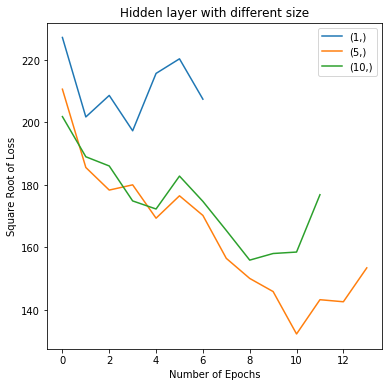

In [35]:
#MLPRegressor has a built-in attribute loss_curve_ which returns the loss at each epoch 
  
#Plot three curves using below conditions (a, b, c) in one figure, 
#where X-axis is epoch number and Y-axis is squared root of loss_curve_ 

#(a) hidden_layer_sizes = (1,)
mlp1 = MLPRegressor(hidden_layer_sizes=(1,), activation='tanh', solver='sgd', learning_rate='constant', 
                    random_state=42, batch_size=30, learning_rate_init=0.005)

#(b) hidden_layer_sizes = (5,)
mlp5 = MLPRegressor(hidden_layer_sizes=(5,), activation='tanh', solver='sgd', learning_rate='constant', 
                    random_state=42, batch_size=30, learning_rate_init=0.005)

#(c) hidden_layer_sizes = (10,)
mlp10 = MLPRegressor(hidden_layer_sizes=(10,), activation='tanh', solver='sgd', learning_rate='constant', 
                    random_state=42, batch_size=30, learning_rate_init=0.005)


#fit models
mlp1.fit(X_train, y_train)
mlp5.fit(X_train, y_train)
mlp10.fit(X_train, y_train)
   

figure(figsize = (6,6))

plot(np.sqrt(mlp1.loss_curve_), label='(1,)')
plot(np.sqrt(mlp5.loss_curve_),label='(5,)')
plot(np.sqrt(mlp10.loss_curve_), label='(10,)')
title('Hidden layer with different size')
xlabel('Number of Epochs')
ylabel('Square Root of Loss')
plt.legend()

# Question 3 - [Kaggle Competition] Mercedes-Benz Greener Manufacturing (25 pts)

In this problem, we are going to explore a Kaggle competition: [Mercedes-Benz Greener Manufacturing](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing). Your goal is to obtain the best score you can in this competition.

The first step is to make a Kaggle account. Then find this competition and read the competition details and the description of the dataset. 

I have converted the categorical variables to numbers. The dataset is available as **'q3_train.csv'** and **'q3_test.csv'** along with the assignment. Please use this dataset for building your models. Upload your predicted values to kaggle to get the score.

Your work should meet the following requirements:

1. Data Preprocessing. 
 * Conduct some data preprocessing. (Hint: see if there is any outlier and remove them).
 * Impute the missing values (if any).
 
2. Predictive Models. 
 * You have to create three models: Lasso regression, Ridge regression and multilayer perceptron. For Lasso and Ridge regression, optimize the alphas using cross validation. Multilayer perceptron can have one hidden layer. You may try other predictive models to get better scores (optional). 
3. Get a score of 0.51 or higher on the **Private Leaderboard**. Take a screenshot of your private score after submission as proof. You can click My Submissions tab to see the history of your submissions. It will show both Public Leaderboard & Private Leaderboard score. Your highes score should be visible in the screenshot.

Briefly describe your work on each of these steps. Explain (very briefly) what approaches you tried, what worked and what did not work. Mention your team's kaggle name and include a screen shot of your public submission score. Finally, try your best to win this competition!

## Answer

### Part 1 

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error

#import the training set

train = pd.read_csv('q3_train.csv')
train[:10]


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,32,23,17,0,3,24,9,14,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,32,21,19,4,3,28,11,14,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,20,24,34,2,3,27,9,23,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,20,21,34,5,3,27,11,4,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,20,23,34,5,3,12,3,13,...,0,0,0,0,0,0,0,0,0,0
5,18,92.93,40,3,25,2,3,11,7,18,...,0,0,1,0,0,0,0,0,0,0
6,24,128.76,9,19,25,5,3,10,7,18,...,0,0,0,0,0,0,0,0,0,0
7,25,91.91,36,13,16,5,3,10,9,0,...,0,0,0,0,0,0,0,0,0,0
8,27,108.67,43,20,16,4,3,10,8,7,...,1,0,0,0,0,0,0,0,0,0
9,30,126.99,31,3,14,2,3,10,0,4,...,0,0,1,0,0,0,0,0,0,0


In [74]:
##this step checks for null values in the training steps. 

missing_df = train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


There seems like there are no missing values.

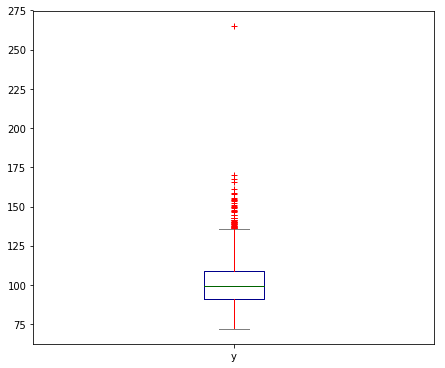

In [75]:
#boxplot of the y variable to see if there are any outliers in the y

fig = plt.figure(figsize=(12,10))
color = dict(boxes = 'DarkBlue', whiskers = 'Red', medians = 'DarkGreen',  caps = 'Gray')
fig.add_subplot(2,2,1)
train['y'].plot.box(color=color, sym='r+')
plt.tight_layout()
plt.show()

There seems like there are no missing values.

In [76]:
#removing the y outlier
train = train.loc[train['y']<175, :]

In [77]:
#this is finding the IQR for all of the columns and then removing any outliers that may exist
cols = train.columns.values[2:]
for i in cols:
    Q1 = train[i].quantile(.25)
    Q3 = train[i].quantile(.75)
    IQR = Q3- Q1
    Q1_outlier = Q1-1.5*IQR
    Q3_outlier = Q3 + 1.5*IQR
    if (Q3 > 2*Q1):
        train = train.loc[train[i]< Q3_outlier]
        train = train.loc[train[i]> Q1_outlier]
        
    #for x in i:
     #   if x < Q1_outlier or x>Q3_outlier:
      #      x= train.replace('null')
len(train)   

4208

There seems to be no outliers in the x variables.

## Part 2

In [78]:
#splitting the train set into training and validation
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

X = train.drop(['y','ID'],axis=1)
y = train['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [79]:
#Lasso
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from patsy import dmatrices
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso,LassoCV,Ridge, LinearRegression, RidgeCV, Ridge
from sklearn import preprocessing
import numpy as np

#alphas range
alphas =  10**np.linspace(10,-6,100)*0.5

#Lasso model with cross validation
lassocv = LassoCV(alphas=alphas, cv=10, max_iter=10000)

g = lassocv.fit(X_train, y_train).alpha_
print ("The chosen lambda is: " ,g)

lassoalpha = Lasso(random_state=50, alpha= g)
lassoalpha.fit(X_train, y_train)
predictlassoalpha = lassoalpha.predict(X_test)
coefslassoalpha = lassoalpha.fit(X_train, y_train).coef_

print ("The mean squared error for LASSO training/test is: " , mean_squared_error(y_test, predictlassoalpha))
CoefLassoDF = pd.DataFrame(coefslassoalpha)

The chosen lambda is:  0.03527401155359316
The mean squared error for LASSO training/test is:  71.16102050450154


In [80]:
#importing test set to make predictions from the training model
dftest = pd.read_csv('q3_test.csv')
test = dftest.drop(['ID'], axis = 1)
testid = dftest['ID']
testid[:10]
#len(test)

0     1
1     2
2     3
3     4
4     5
5     8
6    10
7    11
8    12
9    14
Name: ID, dtype: int64

In [81]:
#predicting y using lasso
from pandas import DataFrame
prediction = lassoalpha.predict(test)
prediction

array([ 78.74848423,  94.63584974,  79.96950282, ...,  94.28088185,
       110.04420138,  95.82702717])

In [82]:
#traing the data using ridge
import warnings
warnings.filterwarnings("ignore")

alphas =  10**np.linspace(10,-6,100)*0.5

ridgecv = RidgeCV(alphas=alphas, cv=10)

g = ridgecv.fit(X_train, y_train).alpha_
print ("The chosen lambda is: " ,g)

ridgealpha = Ridge(random_state=50, alpha= g)
ridgealpha.fit(X_train, y_train)
predictridgealpha = ridgealpha.predict(X_test)
coefsridgealpha = ridgealpha.fit(X_train, y_train).coef_

print ("The mean squared error for LASSO training/test is: " , mean_squared_error(y_test, predictridgealpha))
CoefRidgeDF = pd.DataFrame(coefsridgealpha)

The chosen lambda is:  41.51087840659868
The mean squared error for LASSO training/test is:  73.7726041633386


In [83]:
#prediction of y using ridge 
prediction2 = ridgealpha.predict(test)
prediction2
#DataFrame(prediction2)

array([ 77.86425177,  94.93113706,  81.08587053, ...,  93.55749056,
       110.72237411,  95.48663028])

In [84]:
set(train.columns) - set(test.columns)

{'ID', 'y'}

In [85]:
#(a) hidden_layer_sizes = (1,)
from sklearn.neural_network import MLPRegressor
#fiting the mlp model and predicting y values
mlp1 = MLPRegressor(hidden_layer_sizes=(1,), activation='identity', solver='sgd', learning_rate='constant',
                   random_state=42, batch_size=30, learning_rate_init=0.0001)

from sklearn.neural_network import MLPRegressor

mlpfit = mlp1.fit(X_train, y_train)
mlpredict = mlp1.predict(test)
#DataFrame(mlpredict)

In [86]:
X_train.shape

(2819, 376)

In [87]:
#creating a dataframe containing the ID's, and the predictions from each of the models
df= DataFrame({'ID': testid,
           'prediction':prediction,
          'prediction2': prediction2,
          'mlp_prediction': mlpredict})
df

,ID,prediction,prediction2,mlp_prediction
0,1,78.748484,77.864252,72.373318
1,2,94.635850,94.931137,91.228711
2,3,79.969503,81.085871,74.982491
3,4,78.167500,77.181359,80.529615
4,5,110.583352,109.438749,110.837661
5,8,89.253737,89.290985,90.205432
6,10,110.070514,108.725387,109.065759
7,11,93.965968,93.979737,95.347543
8,12,115.761683,116.959822,116.919171
9,14,95.954932,91.643509,93.805154


In [88]:
#dataframe of just ID and lasso prediction
lasso_df = DataFrame({'ID' : df['ID'], 'Y' : df['prediction']})
lasso_df[:5]
lasso_df.to_csv('lasso_predictions.csv', index = False)


In [89]:
#dataframe of just ID and ridge prediction
ridgedf = DataFrame({'ID' : df['ID'], 'Y' : df['prediction2']})
ridgedf[:5]
ridgedf.to_csv('ridge_predictions.csv', index = False)

In [90]:
#dataframe of just Id and MLP prediction

mlpdf = DataFrame({'ID' : df['ID'], 'Y' : df['mlp_prediction']})
mlpdf[:5]
mlpdf.to_csv('mlp_predictions.csv', index = False)

In [91]:
%matplotlib inline

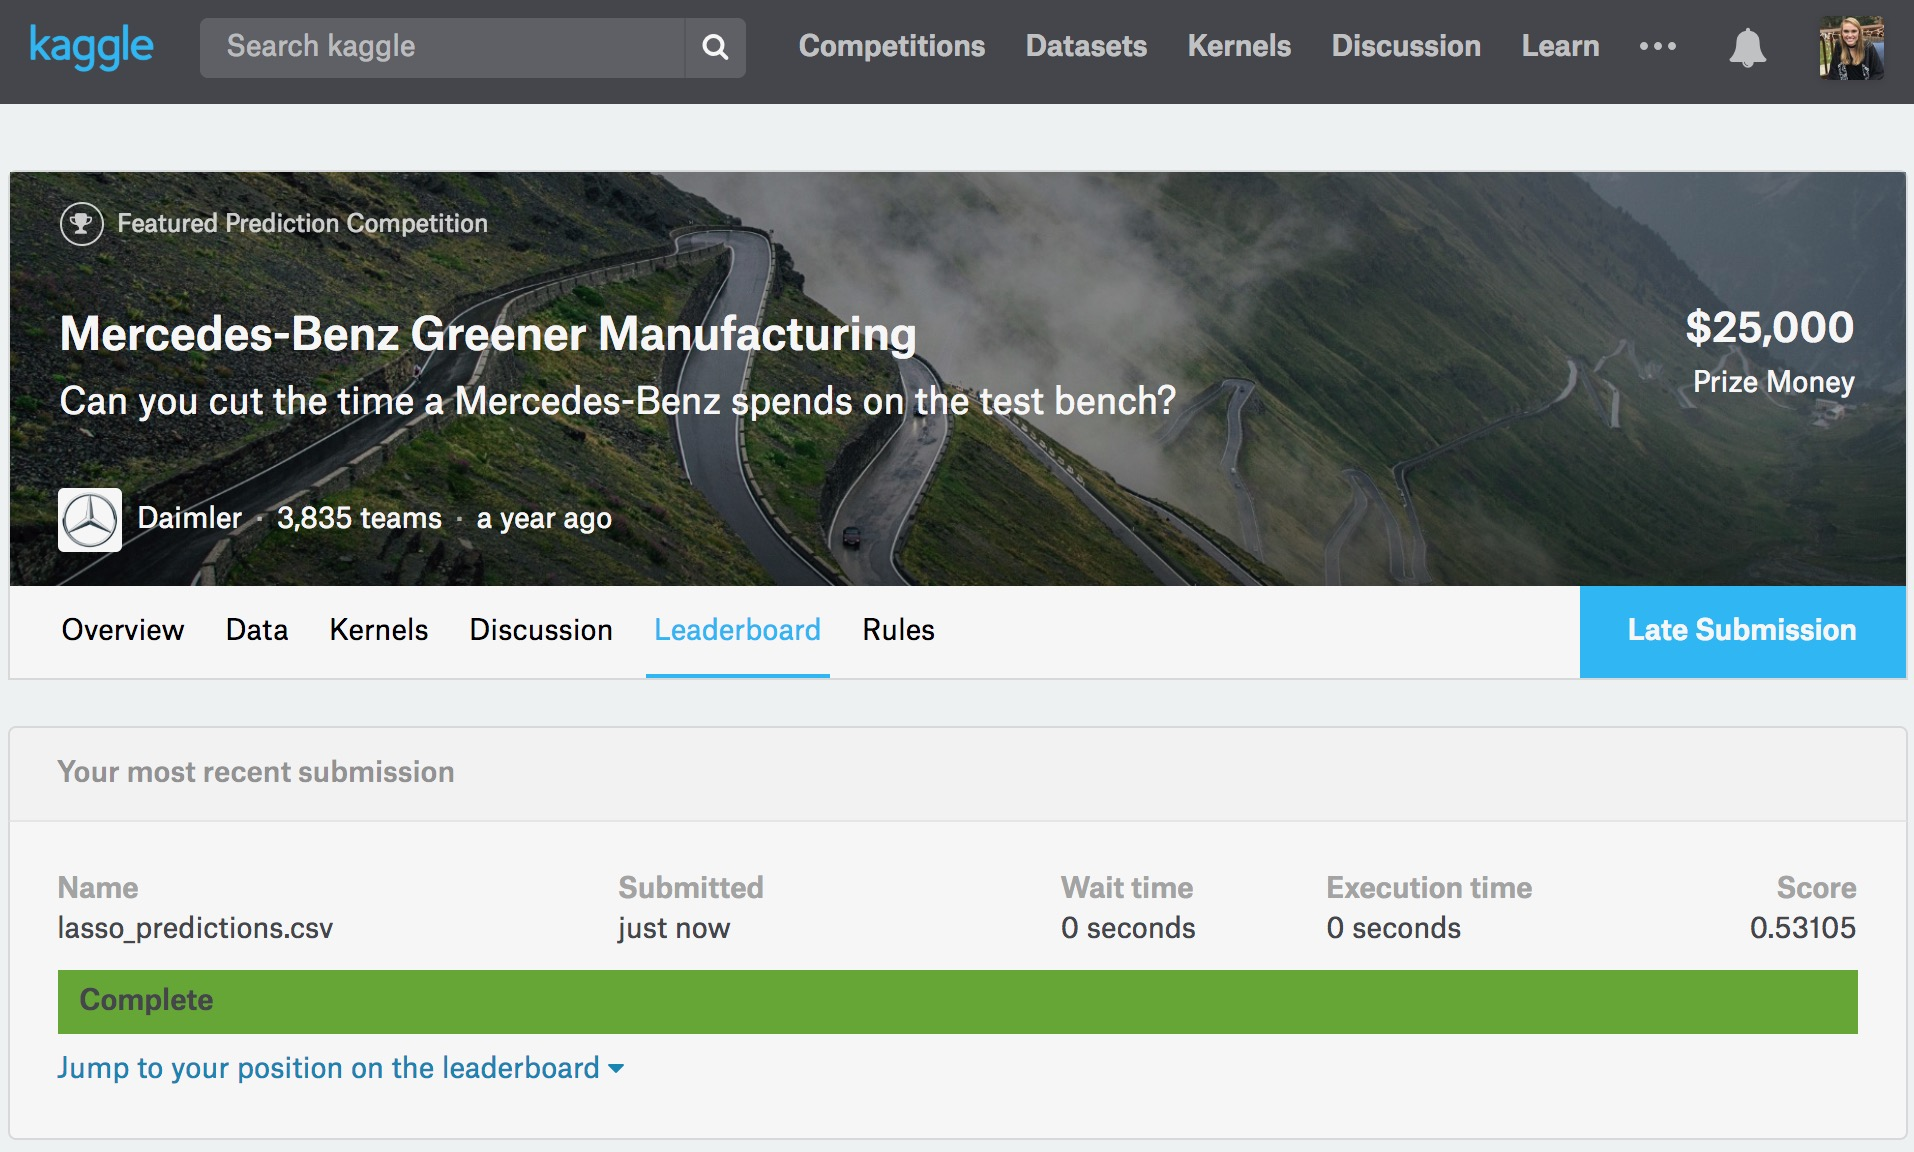

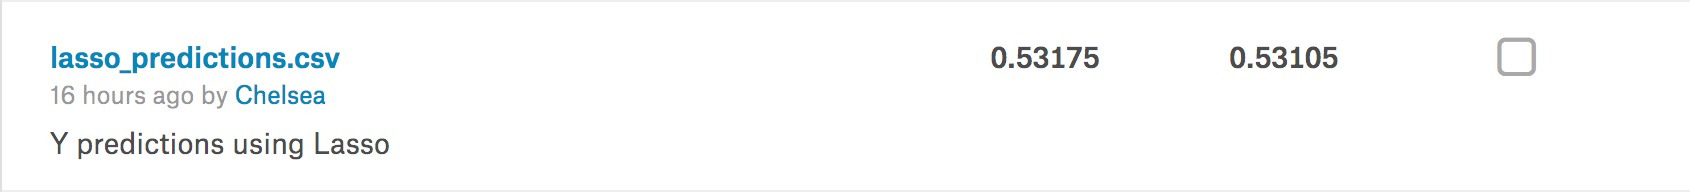

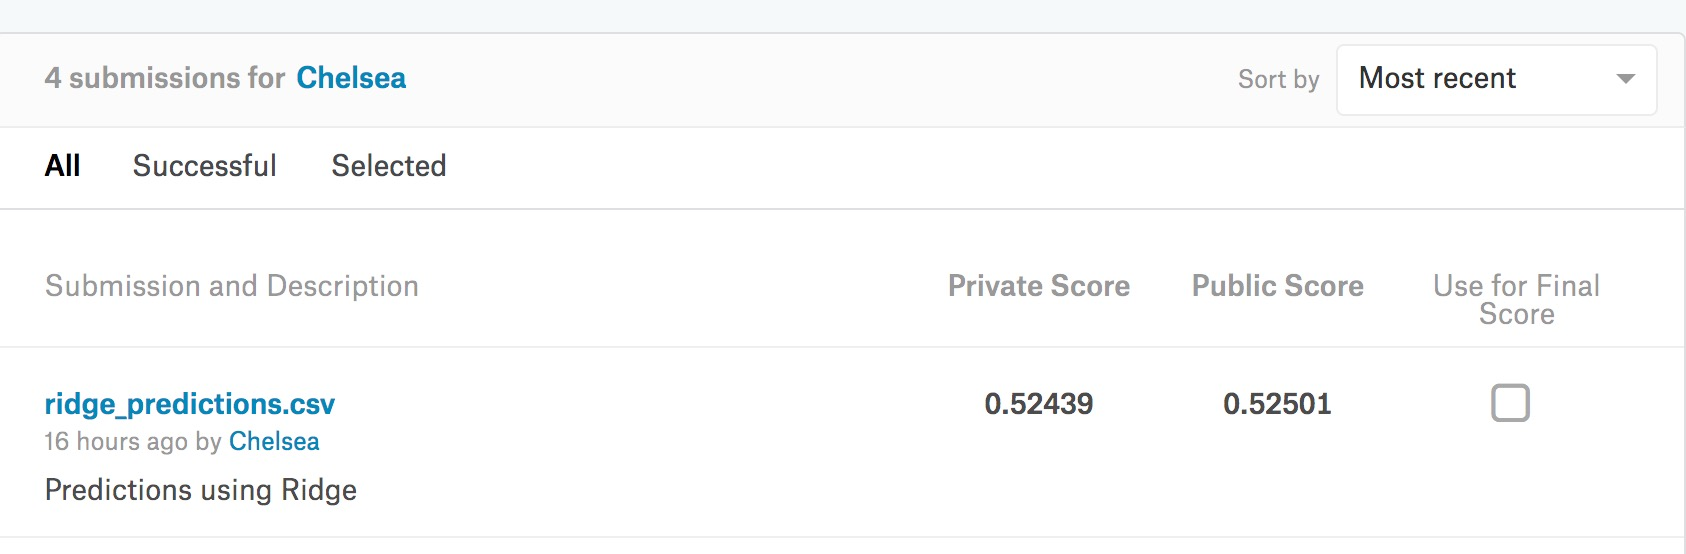

### Concluding Thoughts

The Lasso Model performed better than Ridge or MLP when trying to predict the Y values for the IDs in the dataset. The Lasso recieved a score of 0.53105, while Ridge recieved a 0.52501 and MLP recieved less than a .49. Lasso also had a smaller MSE when evaluating the training set, so the model's performance over Ridge was consistent between training and testing. 

Steps Taken: 
1. First checked to see if there were any missing values 
2. checked for outliers in the y values and removed the outlier that seemed significant
3. checked for and removed any outliers in the predictors (there were not any outliers)
4. Split the train dataset into train and test
5. Fit the lasso model on the training set and then cross validated on the train/test set using the best lambda from the fit. I then used the model that was fitted on the training set to predict teh y-values for the test data set. 
6. repeated the lasso procedure above, this time using ridge
7. fit a mlp model and used it to predict the y values in the test data set. 

# Question 4 - Bayes Decision Theory (10pts)

a. (2pts) Explain what you understand by class-conditional likelihood, class priors, and posterior probability of a class given an input, and the relationship between them. Please define all symbols and equations used explicitly.

b. (5pts) Suppose you want to learn a binary classifier to predict whether or not a customer will buy a TV. The class label is 0 if the patient does not buy and 1 if he/she does. For each customer, you are given two features, x1 is the per hour salary and x2 is the age. Assume that the class conditional distribution $p(x_1,x_2|C)$ is Gaussian. The mean salary and age of the people who do buy a TV is 40 and 27 respectively and that of those who don't is 16 and 20. Assume that both classes of customers have the same covariance given by the Identity matrix. Further, your sales data suggests that only 1 in 5 people actually bought a TV in the last few years. Mathematically derive the (optimal) Bayes decision boundary for this problem.

c. (3pts) Write a script to sample 100 customers from each class (C = 0; 1) under the assumed distribution and the estimated parameters and plot their features. Plot the decision boundary you obtained in the part (b) on the same plot.

## Answer

### a.

Class-conditional liklihood given an input is the probability of a feature given that this feature belongs to a specific class.  We can denote this mathematically with $p(x|A)$ for feature x in class A.

In this case, the class prior is P(A). P(A) represents the probability of getting class A when we are given a data point.

Posterior probability here would be $P(A|x)$, which represents the probability of belonging to class A given the presence of a feature x.  

The relationship between these three can be expressed by $P(A|x) = \cfrac{P(x|A)*P(A)}{P(x)}$

### b.


At the decision boundary- <br>
$P(C_{1}|x_{1},x_{2}) = P(C_{2}|x_{1},x_{2})$ <br>

or <br>

$ln(P(x_{1},x_{2}|C_{1})) + ln(P(C_{1})) = ln(P(x_{1},x_{2}|C_{2})) + ln(P(C_{2}))$ <br>

$\frac{-1}{2}*[(x_{1} - 40)^{2}*(x_{2} - 27)^{2}] + ln(0.2) = \frac{-1}{2}*[(x_{1} - 16)^{2} + (x_{2} - 20)^{2}] + ln(0.8)$ <br>

$\frac{-1}{2}*((x_{1} - 16) + x_{1} - 40)*(x_{1} - 16 - x_{1} + 40) + (x_{2} - 20 + x_{2} - 27)*(x_{2} - 20 - x_{2} + 27)) = 1.3864$ <br>

$(48x_{1} - 1344 + 14x_{2} - 329) = 2.7728$ <br>

$24x_{1} + 7x_{2} = 837.88$ <br>



### c.

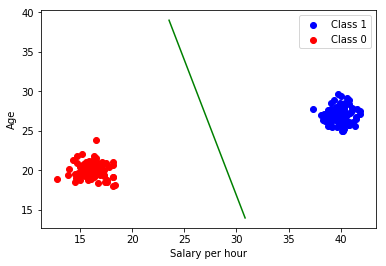

In [40]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB
np.random.seed(42)


mu0 = [40,27]
cov = [[1,0],[0,1]]
mu1 = [16,20]
dist0 = np.random.multivariate_normal(mu0, cov,100)
dist1 = np.random.multivariate_normal(mu1, cov,100)
dec_y = list(range(14,40,1))
dec_x = []
for i in range(26):
    x = (837.886 - 7*dec_y[i])/24.0
    dec_x.append(x)
    
plt.scatter(dist0[:,0],dist0[:,1], c='b', label = "Class 1")
plt.scatter(dist1[:,0],dist1[:,1], c='r', label = "Class 0")
plt.plot(dec_x,dec_y,c='g')
plt.xlabel("Salary per hour")
plt.ylabel("Age")
plt.legend(loc = "best")